# Quantitative Risk Management Assignment

## Import Libraries and Setup

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import os, json, pathlib
import kagglehub
from pathlib import Path
import re

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


## Load Data, Preprocessing, and First Look

In [2]:
path = kagglehub.dataset_download("uciml/default-of-credit-card-clients-dataset")
print("Path to dataset files:", path)

Path to dataset files: /Users/sebastianuedingslohmann/.cache/kagglehub/datasets/uciml/default-of-credit-card-clients-dataset/versions/1


In [3]:
# Load dataset and save as df
base = Path(path)
df = pd.read_csv(base / "UCI_Credit_Card.csv")

In [4]:
print(f'Rows: {df.shape[0]}, Columns: {df.shape[1]}')

Rows: 30000, Columns: 25


In [5]:
display(df.head())

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [6]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [7]:
df.isnull().sum().sort_values()

ID                            0
PAY_AMT5                      0
PAY_AMT4                      0
PAY_AMT3                      0
PAY_AMT2                      0
PAY_AMT1                      0
BILL_AMT6                     0
BILL_AMT5                     0
BILL_AMT4                     0
BILL_AMT3                     0
BILL_AMT2                     0
PAY_AMT6                      0
BILL_AMT1                     0
PAY_5                         0
PAY_4                         0
PAY_3                         0
PAY_2                         0
PAY_0                         0
AGE                           0
MARRIAGE                      0
EDUCATION                     0
SEX                           0
LIMIT_BAL                     0
PAY_6                         0
default.payment.next.month    0
dtype: int64

In [8]:
# Change column name of target variable
df = df.rename(columns={"default.payment.next.month": "default"})
df.columns = [re.sub(r"[^\w]", "_", c).strip("_").lower() for c in df.columns]

# Check if target variable has only 0 and 1 values
assert set(df['default'].unique()) == {0, 1}

In [9]:
# Sex
df['sex'].value_counts(dropna=False).sort_index()

sex
1    11888
2    18112
Name: count, dtype: int64

In [10]:
# Education
df['education'].value_counts(dropna=False).sort_index()

education
0       14
1    10585
2    14030
3     4917
4      123
5      280
6       51
Name: count, dtype: int64

In [11]:
# Mapping education values 0, 5, 6 to 7 (unknown) (others remain unchanged)
edu_map = {0: 7, 5: 7, 6: 7}
df["education"] = df["education"].replace(edu_map).astype("int64")
print(df["education"].value_counts().sort_index())

education
1    10585
2    14030
3     4917
4      123
7      345
Name: count, dtype: int64


In [12]:
# Marriage
df['marriage'].value_counts(dropna=False).sort_index()

marriage
0       54
1    13659
2    15964
3      323
Name: count, dtype: int64

In [13]:
# Payment status columns
for c in [col for col in df.columns if re.fullmatch(r"pay_[0-6]", col)]:
    print(f"\n{c}:\n{df[c].value_counts(dropna=False).sort_index()}")


pay_0:
pay_0
-2     2759
-1     5686
 0    14737
 1     3688
 2     2667
 3      322
 4       76
 5       26
 6       11
 7        9
 8       19
Name: count, dtype: int64

pay_2:
pay_2
-2     3782
-1     6050
 0    15730
 1       28
 2     3927
 3      326
 4       99
 5       25
 6       12
 7       20
 8        1
Name: count, dtype: int64

pay_3:
pay_3
-2     4085
-1     5938
 0    15764
 1        4
 2     3819
 3      240
 4       76
 5       21
 6       23
 7       27
 8        3
Name: count, dtype: int64

pay_4:
pay_4
-2     4348
-1     5687
 0    16455
 1        2
 2     3159
 3      180
 4       69
 5       35
 6        5
 7       58
 8        2
Name: count, dtype: int64

pay_5:
pay_5
-2     4546
-1     5539
 0    16947
 2     2626
 3      178
 4       84
 5       17
 6        4
 7       58
 8        1
Name: count, dtype: int64

pay_6:
pay_6
-2     4895
-1     5740
 0    16286
 2     2766
 3      184
 4       49
 5       13
 6       19
 7       46
 8        2
Name: count, dtype

In [14]:
# Bill amount columns
bill_cols = [c for c in df.columns if re.fullmatch(r"bill_amt[1-6]", c)]
df[bill_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
bill_amt1,30000.0,51223.330900,73635.860576,-165580.0,3558.75,22381.5,67091.00,964511.0
bill_amt2,30000.0,49179.075167,71173.768783,-69777.0,2984.75,21200.0,64006.25,983931.0
bill_amt3,30000.0,47013.154800,69349.387427,-157264.0,2666.25,20088.5,60164.75,1664089.0
bill_amt4,30000.0,43262.948967,64332.856134,-170000.0,2326.75,19052.0,54506.00,891586.0
bill_amt5,30000.0,40311.400967,60797.155770,-81334.0,1763.00,18104.5,50190.50,927171.0
bill_amt6,30000.0,38871.760400,59554.107537,-339603.0,1256.00,17071.0,49198.25,961664.0


In [15]:
# Pay amount columns
pay_amt_cols = [c for c in df.columns if re.fullmatch(r"pay_amt[1-6]", c)]
df[pay_amt_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
pay_amt1,30000.0,5663.580500,16563.280354,0.0,1000.00,2100.0,5006.00,873552.0
pay_amt2,30000.0,5921.163500,23040.870402,0.0,833.00,2009.0,5000.00,1684259.0
pay_amt3,30000.0,5225.681500,17606.961470,0.0,390.00,1800.0,4505.00,896040.0
pay_amt4,30000.0,4826.076867,15666.159744,0.0,296.00,1500.0,4013.25,621000.0
pay_amt5,30000.0,4799.387633,15278.305679,0.0,252.50,1500.0,4031.50,426529.0
pay_amt6,30000.0,5215.502567,17777.465775,0.0,117.75,1500.0,4000.00,528666.0


In [16]:
# Check if target variable has only 0 and 1 values
assert set(df['default'].unique()) == {0, 1}

In [17]:
sex_dummies = pd.get_dummies(df["sex"], prefix="sex")
df = pd.concat([df, sex_dummies], axis=1)

In [18]:
marriage_dummies = pd.get_dummies(df["marriage"], prefix="marriage")
df = pd.concat([df, marriage_dummies], axis=1)

In [19]:
edu_dummies = pd.get_dummies(df["education"], prefix="education")
df = pd.concat([df, edu_dummies], axis=1)

In [20]:
# Drop original categorical columns as well as one dummy variable from each to avoid multicollinearity
df = df.drop(columns=['sex', 'sex_2', 'education', 'education_7', 'marriage', 'marriage_3'])
df.head()


,id,limit_bal,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,...,pay_amt6,default,sex_1,marriage_0,marriage_1,marriage_2,education_1,education_2,education_3,education_4
0,1,20000.0,24,2,2,-1,-1,-2,-2,3913.0,...,0.0,1,False,False,True,False,False,True,False,False
1,2,120000.0,26,-1,2,0,0,0,2,2682.0,...,2000.0,1,False,False,False,True,False,True,False,False
2,3,90000.0,34,0,0,0,0,0,0,29239.0,...,5000.0,0,False,False,False,True,False,True,False,False
3,4,50000.0,37,0,0,0,0,0,0,46990.0,...,1000.0,0,False,False,True,False,False,True,False,False
4,5,50000.0,57,-1,0,-1,0,0,0,8617.0,...,679.0,0,True,False,True,False,False,True,False,False


## Feature Engineering

In [21]:
pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

df['max_late_payment'] = df[pay_cols].max(axis=1)
df['num_late_payments'] = (df[pay_cols] > 0).sum(axis=1)
df['recent_late_payment'] = (df['pay_0'] > 0).astype(int)
df['delay_trend_overall'] = df['pay_0'].clip(lower=0) - df['pay_6'].clip(lower=0)
df['num_fully_paid'] = (df[pay_cols] == -1).sum(axis=1)
df['num_inactive_months'] = (df[pay_cols] == -2).sum(axis=1)

In [22]:
bill_cols = ['bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6']

df['bill_mean'] = df[bill_cols].mean(axis=1)
df['bill_std'] = df[bill_cols].std(axis=1)
df['bill_trend'] = df['bill_amt1'] - df['bill_amt6']


In [23]:
df.head()

,id,limit_bal,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,...,education_4,max_late_payment,num_late_payments,recent_late_payment,delay_trend_overall,num_fully_paid,num_inactive_months,bill_mean,bill_std,bill_trend
0,1,20000.0,24,2,2,-1,-1,-2,-2,3913.0,...,False,2,2,1,2,2,2,1284.000000,1761.633219,3913.0
1,2,120000.0,26,-1,2,0,0,0,2,2682.0,...,False,2,2,0,-2,1,0,2846.166667,637.967841,-579.0
2,3,90000.0,34,0,0,0,0,0,0,29239.0,...,False,0,0,0,0,0,0,16942.166667,6064.518593,13690.0
3,4,50000.0,37,0,0,0,0,0,0,46990.0,...,False,0,0,0,0,0,0,38555.666667,10565.793518,17443.0
4,5,50000.0,57,-1,0,-1,0,0,0,8617.0,...,False,0,0,0,0,2,0,18223.166667,10668.590074,-10514.0


## Exploratory Data Analysis

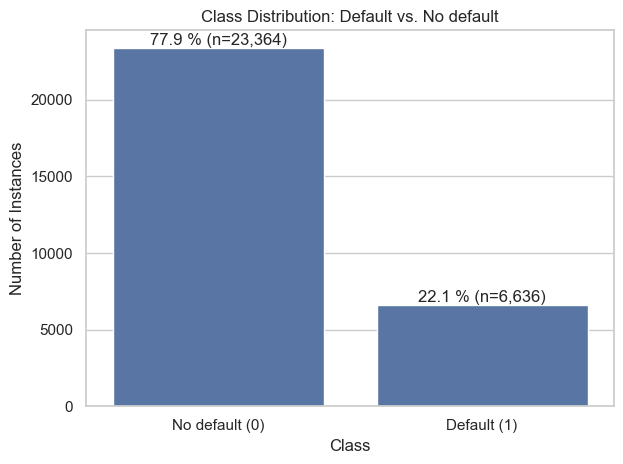

In [24]:
# Visualize the class imbalance in a barplot
sns.set_theme(style="whitegrid")

counts = df["default"].value_counts().sort_index()
pcts   = (df["default"].value_counts(normalize=True)
         .sort_index()
         .mul(100).round(1))

labels = ["No default (0)", "Default (1)"]

ax = sns.barplot(x=labels, y=counts.values)
ax.set_xlabel("Class")
ax.set_ylabel("Number of Instances")
ax.set_title("Class Distribution: Default vs. No default")

for i, (n, p) in enumerate(zip(counts.values, pcts.values)):
    ax.text(i, n, f"{p} % (n={n:,})", ha="center", va="bottom")

plt.tight_layout()
plt.show()

Class_weight = 'balanced' necessary

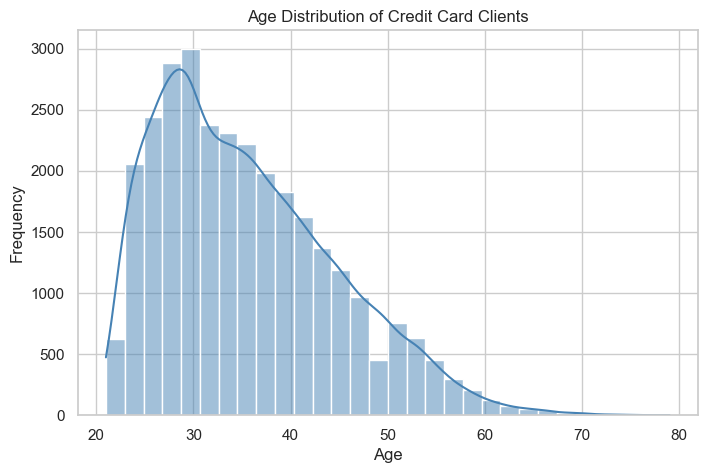

In [25]:
plt.figure(figsize=(8,5))
sns.histplot(df['age'], bins=30, kde=True, color='steelblue')
plt.title('Age Distribution of Credit Card Clients')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

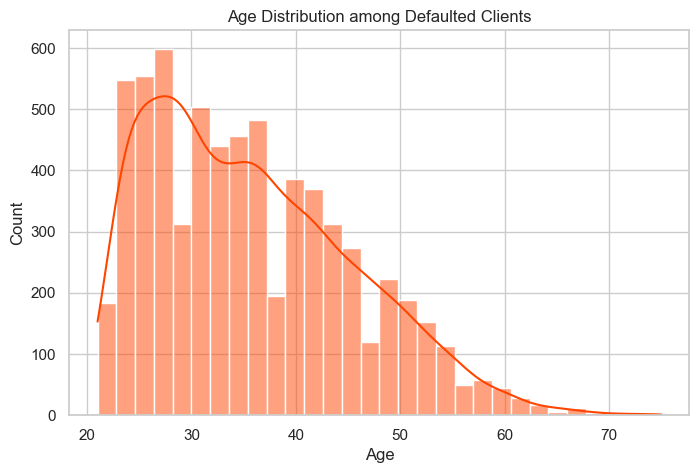

In [26]:
df_default = df[df["default"] == 1]

plt.figure(figsize=(8,5))
sns.histplot(
    data=df_default,
    x="age",
    bins=30,
    kde=True,
    color="orangered",
)
plt.title("Age Distribution among Defaulted Clients")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

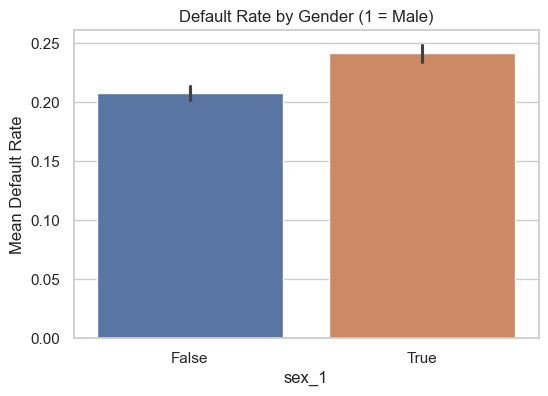

In [27]:
plt.figure(figsize=(6,4))
sns.barplot(data=df, x="sex_1", y="default", estimator=lambda x: np.mean(x), hue = "sex_1", legend = False)
plt.title("Default Rate by Gender (1 = Male)")
plt.ylabel("Mean Default Rate")
plt.show()

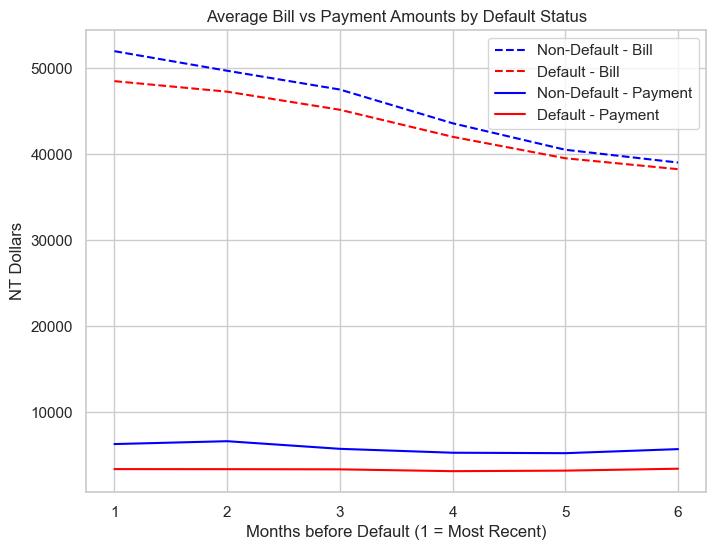

In [28]:
months = np.arange(1, 7)

bill_cols = [f"bill_amt{i}" for i in range(1, 7)]
pay_cols  = [f"pay_amt{i}" for i in range(1, 7)]

mean_bill = df.groupby("default")[bill_cols].mean().T
mean_pay  = df.groupby("default")[pay_cols].mean().T

plt.figure(figsize=(8,6))

# Bill amounts
plt.plot(months, mean_bill.loc[bill_cols, 0], '--', label="Non-Default - Bill", color='blue')
plt.plot(months, mean_bill.loc[bill_cols, 1], '--', label="Default - Bill", color='red')

# Payment amounts
plt.plot(months, mean_pay.loc[pay_cols, 0], '-', label="Non-Default - Payment", color='blue')
plt.plot(months, mean_pay.loc[pay_cols, 1], '-', label="Default - Payment", color='red')

plt.title("Average Bill vs Payment Amounts by Default Status")
plt.xlabel("Months before Default (1 = Most Recent)")
plt.ylabel("NT Dollars")
plt.legend()
plt.show()

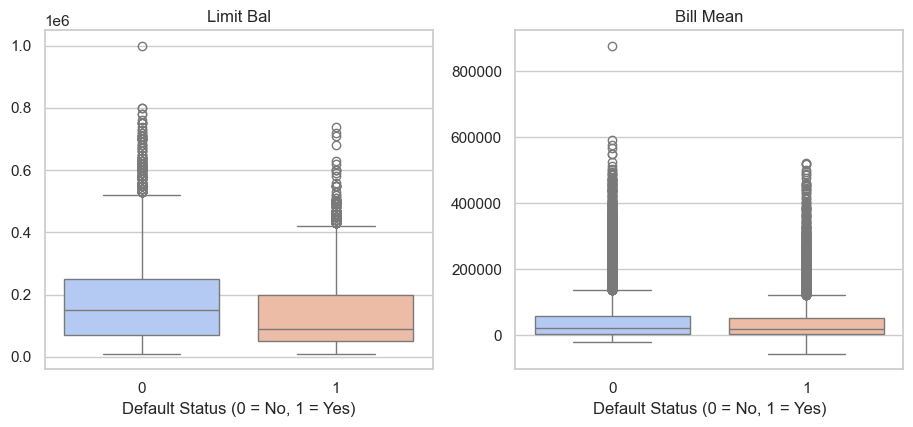

In [29]:
features = ['limit_bal', 'bill_mean']

# Layout vorbereiten
plt.figure(figsize=(14, 8))
for i, col in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(
        data=df,
        x='default',
        y=col,
        palette='coolwarm',
        hue = 'default',
        legend = False,
    )
    plt.title(col.replace('_', ' ').title())
    plt.xlabel('Default Status (0 = No, 1 = Yes)')
    plt.ylabel('')
plt.tight_layout()
plt.show()

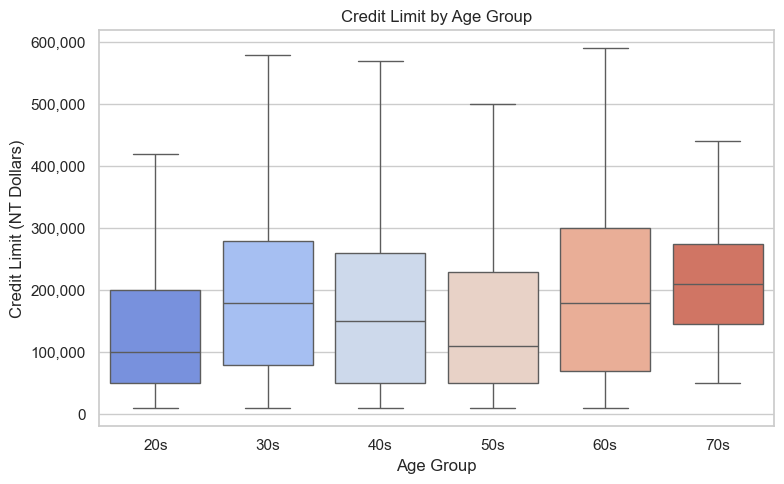

In [30]:
df["age_group"] = pd.cut(
    df["age"],
    bins=[20, 30, 40, 50, 60, 70, 80],
    labels=["20s", "30s", "40s", "50s", "60s", "70s"])

plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df,
    x="age_group",
    y="limit_bal",
    palette="coolwarm",
    hue="age_group",
    legend = False,
    showfliers=False)

plt.title("Credit Limit by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Credit Limit (NT Dollars)")

formatter = FuncFormatter(lambda x, _: f"{int(x):,}")
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

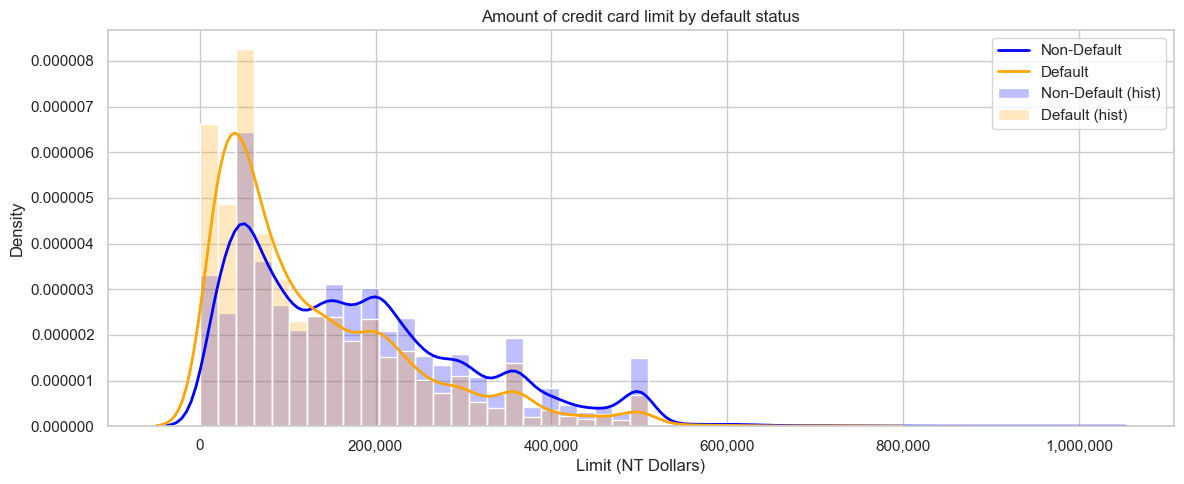

In [31]:
plt.figure(figsize=(12, 5))

bins = np.linspace(0, df["limit_bal"].max(), 50)

sns.histplot(
    df.loc[df["default"] == 0, "limit_bal"],
    bins=bins,
    stat="density",
    color="blue",
    alpha=0.25,
    label="Non-Default (hist)")
sns.kdeplot(
    df.loc[df["default"] == 0, "limit_bal"],
    color="blue",
    lw=2,
    label="Non-Default")

sns.histplot(
    df.loc[df["default"] == 1, "limit_bal"],
    bins=bins,
    stat="density",
    color="orange",
    alpha=0.25,
    label="Default (hist)")
sns.kdeplot(
    df.loc[df["default"] == 1, "limit_bal"],
    color="orange",
    lw=2,
    label="Default")

plt.title("Amount of credit card limit by default status")
plt.xlabel("Limit (NT Dollars)")
plt.ylabel("Density")

x_formatter = FuncFormatter(lambda x, _: f"{int(x):,}")
plt.gca().xaxis.set_major_formatter(x_formatter)

plt.ticklabel_format(axis="y", style="plain")

plt.legend()
plt.tight_layout()
plt.show()


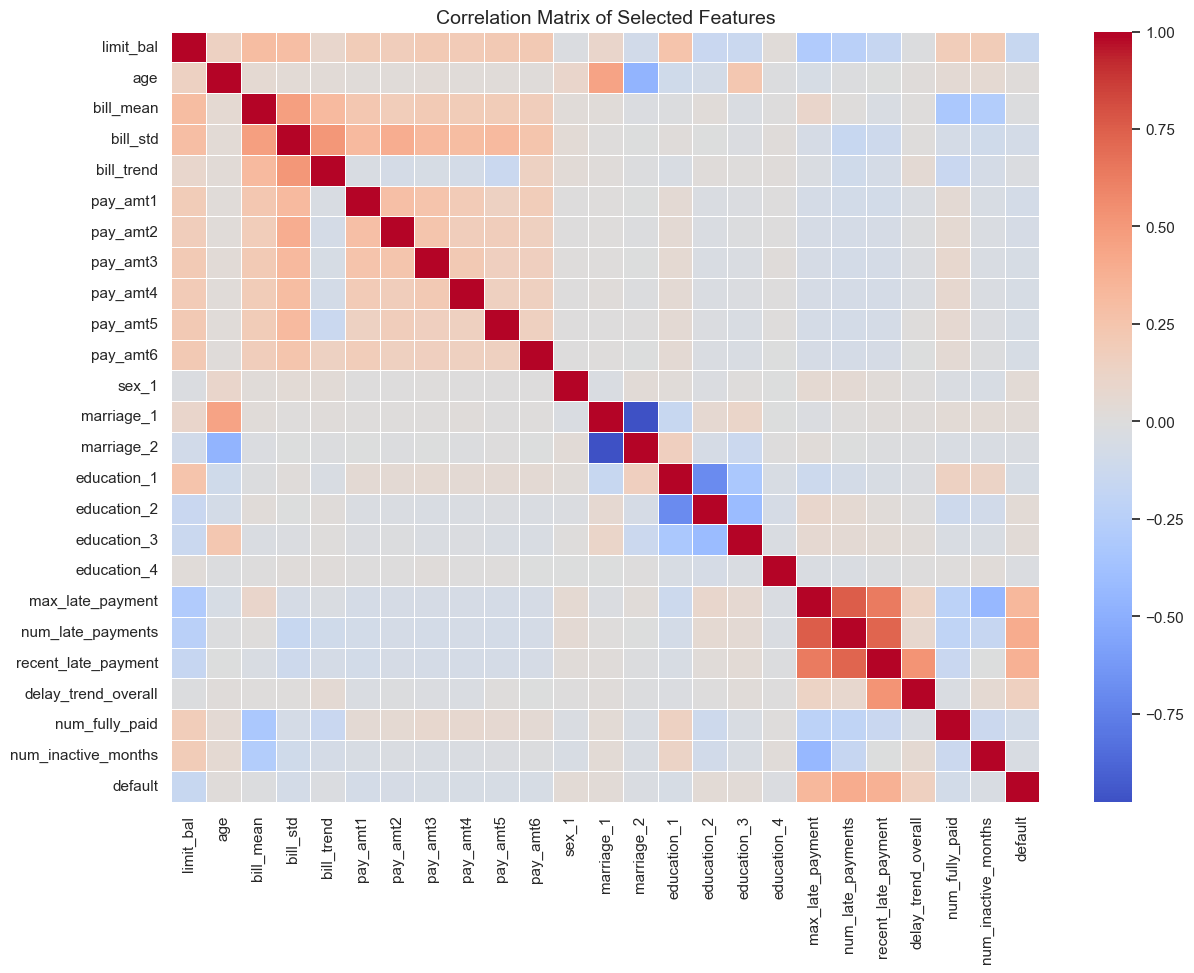

In [32]:
feature_cols = ['limit_bal', 'age', 'bill_mean', 'bill_std', 'bill_trend', 'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6', 'sex_1', 'marriage_1', 'marriage_2', 'education_1', 'education_2', 'education_3', 'education_4', 'max_late_payment', 'num_late_payments', 'recent_late_payment', 'delay_trend_overall', 'num_fully_paid', 'num_inactive_months']
corr_features = feature_cols + ["default"]

corr = df[corr_features].corr(numeric_only=True)

plt.figure(figsize=(14, 10))
sns.heatmap(corr, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Correlation Matrix of Selected Features", fontsize=14)
plt.show()

Leaving features even if there is some correlation, will be taken care of by L2 regularisation.

## Modeling

In [33]:
y = df['default'].astype('int64')
X = df[feature_cols]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [35]:
scale_cols = [
    'limit_bal', 'age', 
    'bill_mean', 'bill_std', 'bill_trend',
    'pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
    'max_late_payment', 'num_late_payments', 'recent_late_payment',
    'delay_trend_overall', 'num_fully_paid', 'num_inactive_months']

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_test_scaled[scale_cols] = scaler.transform(X_test[scale_cols])

In [36]:
model = LogisticRegression(max_iter = 1000, random_state = 42, class_weight = 'balanced', penalty = 'l2')
model.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [37]:
proba = model.predict_proba(X_test_scaled)[:, 1]
pred  = (proba >= 0.5).astype(int)

In [38]:
print("ROC-AUC:", round(roc_auc_score(y_test, proba), 4))
print("\nConfusion matrix:\n", confusion_matrix(y_test, pred))
print("\nReport:\n", classification_report(y_test, pred, digits=3))

ROC-AUC: 0.7518

Confusion matrix:
 [[3740  933]
 [ 532  795]]

Report:
               precision    recall  f1-score   support

           0      0.875     0.800     0.836      4673
           1      0.460     0.599     0.520      1327

    accuracy                          0.756      6000
   macro avg      0.668     0.700     0.678      6000
weighted avg      0.784     0.756     0.766      6000



In [39]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(len(y_train[y_train==0]) / len(y_train[y_train==1])),  # Klassenbalance
    eval_metric='auc',
    random_state=42,
    n_jobs=-1)

xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


ROC-AUC: 0.7771649445716715

Confusion matrix:
 [[3686  987]
 [ 484  843]]

Classification report:
               precision    recall  f1-score   support

           0       0.88      0.79      0.83      4673
           1       0.46      0.64      0.53      1327

    accuracy                           0.75      6000
   macro avg       0.67      0.71      0.68      6000
weighted avg       0.79      0.75      0.77      6000



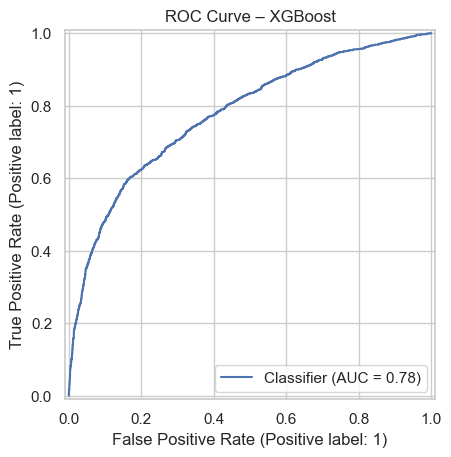

In [40]:
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve – XGBoost")
plt.show()

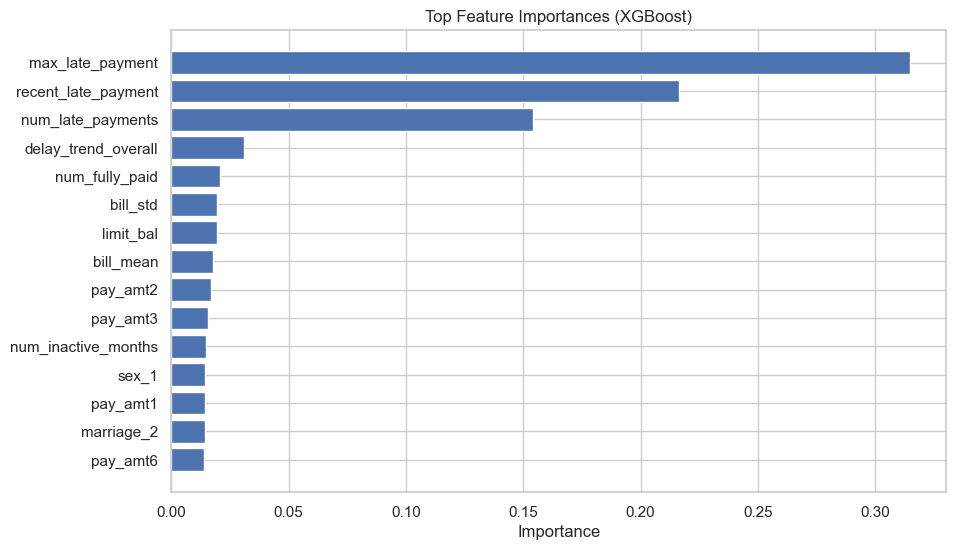

In [41]:
importances = xgb.feature_importances_
features = X_train.columns

plt.figure(figsize=(10,6))
sorted_idx = importances.argsort()[::-1][:15]  # Top 15 Features
plt.barh(features[sorted_idx][::-1], importances[sorted_idx][::-1])
plt.title("Top Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.show()

In [42]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')])

/Users/sebastianuedingslohmann/Desktop/QRM/Quantitative-Risk-Management/.venv64/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])


In [44]:
early_stop = EarlyStopping(monitor='val_auc', patience=6, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1)


Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 985us/step - accuracy: 0.7837 - auc: 0.7081 - loss: 0.5001 - val_accuracy: 0.8094 - val_auc: 0.7686 - val_loss: 0.4540
Epoch 2/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - accuracy: 0.8062 - auc: 0.7443 - loss: 0.4592 - val_accuracy: 0.8083 - val_auc: 0.7700 - val_loss: 0.4523
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - accuracy: 0.8097 - auc: 0.7502 - loss: 0.4514 - val_accuracy: 0.8079 - val_auc: 0.7746 - val_loss: 0.4473
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - accuracy: 0.8108 - auc: 0.7571 - loss: 0.4460 - val_accuracy: 0.8090 - val_auc: 0.7747 - val_loss: 0.4475
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - accuracy: 0.8131 - auc: 0.7617 - loss: 0.4425 - val_accuracy: 0.8098 - val_auc: 0.7773 - val_loss: 0.4458
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - accuracy: 0.8127 - auc: 0.7650 - loss: 0.4402 - val_accuracy: 0.8083 - val_auc: 0.7764 - val_loss: 0.4463
Epoch 7/30
300/300 ━━━━━━━━━

In [45]:
y_pred_proba = model.predict(X_test_scaled).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
ROC-AUC: 0.7710922032661777

Confusion Matrix:
 [[4382  291]
 [ 817  510]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89      4673
           1       0.64      0.38      0.48      1327

    accuracy                           0.82      6000
   macro avg       0.74      0.66      0.68      6000
weighted avg       0.80      0.82      0.80      6000



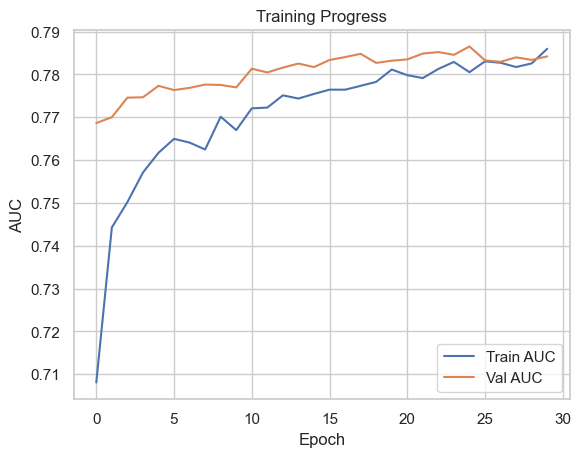

In [46]:
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.title('Training Progress')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()
